## Initialization

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

#The goal of this project is to determine the age of individuals buying alcohol at a store with the highest accuracy possible.  FIrst we are going to load the label file into the system then we will use a ImageDataGenerator to load the actual pictures into the system.  From there we will be building nueral networks and tuning the layers to try and get the most accurate prediction possible.  

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)

## EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None

          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000



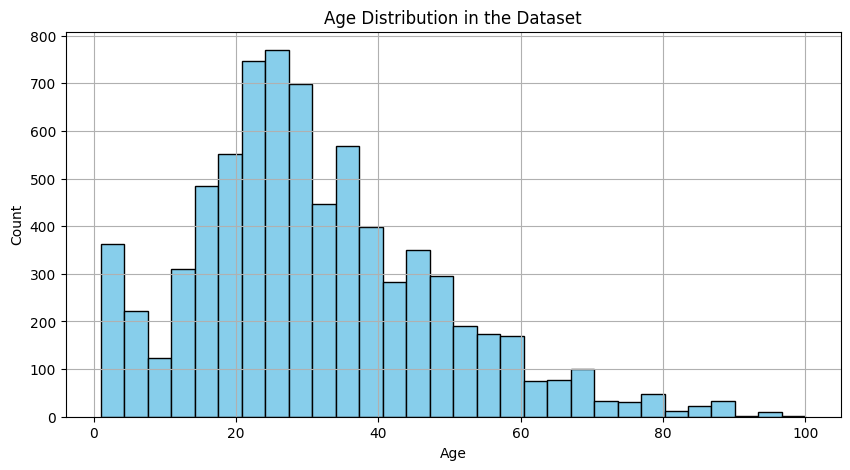

In [2]:
import matplotlib.pyplot as plt

print(labels.info())
print()
print(labels.describe())
print()

plt.figure(figsize=(10, 5))
labels['real_age'].hist(bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution in the Dataset")
plt.show()

### Findings

#The data has a positive skew with most of the data points floating around the median of 29.  There are some large outliers getting up there in the 90s age and it appears there is a quite a bit of photos of people under the age of 10 (about 700 out of the 7,600 photos).  The labels file only contains 2 columns, the file name of the photo and the real age of the person in the photo.

## Modeling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [3]:
import tensorflow as tf

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [4]:
import os
print(os.listdir('/datasets/faces/final_files/'))

['006902.jpg', '003356.jpg', '002627.jpg', '004085.jpg', '005138.jpg', '004409.jpg', '000845.jpg', '001574.jpg', '003518.jpg', '004247.jpg', '000683.jpg', '006029.jpg', '002465.jpg', '006740.jpg', '003194.jpg', '001736.jpg', '003437.jpg', '002708.jpg', '004166.jpg', '005219.jpg', '002384.jpg', '005930.jpg', '000926.jpg', '001655.jpg', '005057.jpg', '004328.jpg', '000764.jpg', '001493.jpg', '002546.jpg', '007550.jpg', '003275.jpg', '006821.jpg', '001817.jpg', '001970.jpg', '005534.jpg', '004805.jpg', '001259.jpg', '006263.jpg', '003752.jpg', '004481.jpg', '007316.jpg', '003590.jpg', '002861.jpg', '007154.jpg', '006425.jpg', '003914.jpg', '000368.jpg', '005372.jpg', '004643.jpg', '001097.jpg', '002780.jpg', '002069.jpg', '005615.jpg', '006344.jpg', '000287.jpg', '003833.jpg', '005291.jpg', '004562.jpg', '003671.jpg', '002942.jpg', '007235.jpg', '006506.jpg', '000449.jpg', '005453.jpg', '001178.jpg', '004724.jpg', '006182.jpg', '002663.jpg', '001934.jpg', '003392.jpg', '006227.jpg', '0044

In [ ]:
def load_train():
    
    """
    It loads the train part of dataset from path
    """
    train_gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/', 
    x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size = 32,
    class_mode='raw',
    subset='training',
    seed=12345)

    return train_gen_flow

Found 5694 validated image filenames.


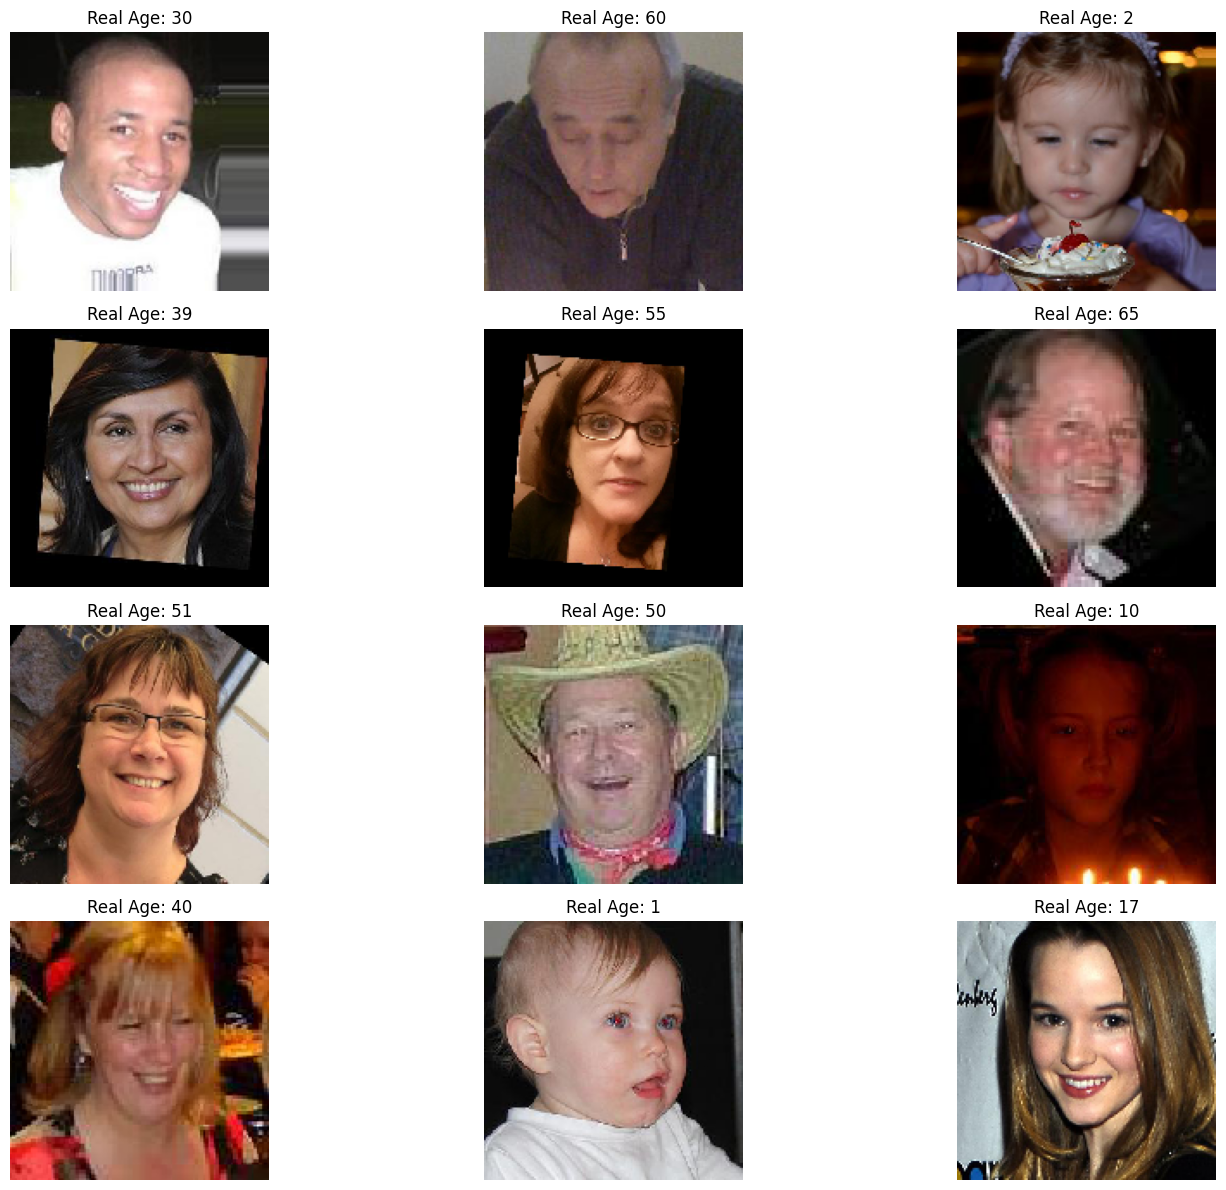

In [8]:
features, target = next(load_train())
fig, axes = plt.subplots(4,3, figsize=(16, 12))
axes = axes.flatten()

for i in range(12):
    axes[i].imshow(features[i+12])
    axes[i].set_title(f'Real Age: {target[i+12]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def load_test():
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_gen_flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age', 
    target_size=(150, 150),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
    
    return test_gen_flow

load_test()

Found 1897 validated image filenames.


In [ ]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    model = Sequential([
        #1st Layer
        Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        MaxPooling2D(pool_size=(2,2)),
        #2nd Layer
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        #3rd Conv Layer
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )

    test_loss, test_mae = model.evaluate(test_data)
    print(f"Test Loss (MSE): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    return model



### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [13]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

## Conclusions

#Based off our analysis we have created a model with an MAE that scored a 6.64 on its best epoch.  The model is fairly accurate in predicting the actual age of the people based off the photograph.  For the sprint we first loaded the data then analyzed what the labels file looked like.  It only contained the age and the name of the file.  We then analyzed the age data to get descriptive statistics on it.   From there we plotted the distribution of the ages to get an idea of the range of data we are looking at.  Then we used ImageDataGenerator and loaded the train and test data.  Then we created the model with different variables and trained it.  The models goal was a maximum MAE of 8 and we achieved that in 15 of the 20 epochs.

# Checklist

- [X]  Notebook was opened
- [X]  The code is error free
- [X]  The cells with code have been arranged by order of execution
- [X]  The exploratory data analysis has been performed
- [X]  The results of the exploratory data analysis are presented in the final notebook
- [X]  The model's MAE score is not higher than 8
- [X]  The model training code has been copied to the final notebook
- [X]  The model training output has been copied to the final notebook
- [X]  The findings have been provided based on the results of the model training